# **Customer Segmentation**

Pada repo kali ini saya akan membahas tentang membagi beberapa tipe customer berdasarkan potensi dan loyalty pada sebuah perusahaan. Metode yang akan digunakan adalah Clustering menggunakan K-Means. Customer Segmentation ini sangat berguna untuk digunakan oleh tim marketing ataupun sebagai data kalian yang memiliki usaha agar dapat memilih customer mana yang lebih potensial untuk menghasilkan revenue.

Maksud dari Customer Segmentation sendiri adalah kegiatan membagi konsumen yang luas atau pasar bisnis, biasanya terdiri dari pelanggan yang sudah exist dan potensial, dibagi menjadi sub-kelompok konsumen (dikenal sebagai segmen) berdasarkan pada beberapa jenis karakteristik. Tujuan keseluruhan segmentasi adalah untuk mengidentifikasi segmen dengan hasil tinggi - yaitu segmen yang paling menguntungkan atau yang memiliki potensi pertumbuhan - sehingga dapat dipilih untuk mendapat perhatian khusus.

## **Apa Saja yang Akan Kita Bahas?**

- Cleaning/Transforming the Data
- Univariate Analysis
- Menganalisis KPI
    1. Pendapatan Tahunan
    2. Penghasilan Bulanan
    3. Tingkat pertumbuhan Pendapatan Bulanan
    4. Pelanggan Aktif Bulanan
    5. Penjualan Rata-rata per Pesanan
    6. Tingkat Pertumbuhan Pelanggan Baru
- Clustering dengan jumlah cluster yang berubah-ubah
    1. Menghitung nilai Recency, Frequency and Monetary untuk setiap pelanggan
    2. Menghitung RFM Score
    3. Membagi pelanggan menjadi beberapa segmen
- KMeans Clustering
- Data Preprocessing for KMeans
    1. Menghapus Skewness untuk mencapai distribusi Normal menggunakan Log Transformation
    2. Standarisasi variabel menggunakan Standard Scaler untuk varians equal dan equal mean
    3. Memilih jumlah cluster menggunakan Elbow Method
    4. Implementing KMeans
    5. Membangun Persona Pelanggan
        a. Snake Plot
        b. Perhitungan kepentingan relatif setiap cluster dibandingkan dengan populasi

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Reading the data

In [2]:
df = pd.read_csv('data_sample_sales.csv', encoding = 'unicode_escape')
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


### Checking for null values

In [3]:
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

**Objective:**

Kita tidak akan berurusan dengan nilai-nilai variabel 'Wilayah' yang hilang karena mungkin tidak memiliki pengaruh yang signifikan terhadap analisis.

### Hapus variabel yang tidak memiliki nilai signifikan untuk analisis kita

In [4]:
to_drop = ['PHONE','ADDRESSLINE1','ADDRESSLINE2','STATE','POSTALCODE']
df = df.drop(to_drop, axis=1)

### Checking for inconsistent data types

In [5]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

### Mengubah tipe data kolom 'ORDERDATE' dari object menjadi datetime

In [6]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

Summary stats of Quantitative variables

In [7]:
desc = ['QUANTITYORDERED','PRICEEACH','SALES','MSRP']
df[desc].describe()

,QUANTITYORDERED,PRICEEACH,SALES,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000
mean,35.092809,83.658544,3553.889072,100.715551
std,9.741443,20.174277,1841.865106,40.187912
min,6.000000,26.880000,482.130000,33.000000
25%,27.000000,68.860000,2203.430000,68.000000
50%,35.000000,95.700000,3184.800000,99.000000
75%,43.000000,100.000000,4508.000000,124.000000
max,97.000000,100.000000,14082.800000,214.000000


**Objective:**

Tabel di atas menunjukkan bahwa tidak ada nilai negatif untuk variabel kuantitatif, yang merupakan pertanda baik karena kita tidak dapat memiliki harga atau kuantitas negatif.

## Exploring the variables

**Order Quantity Distribution**

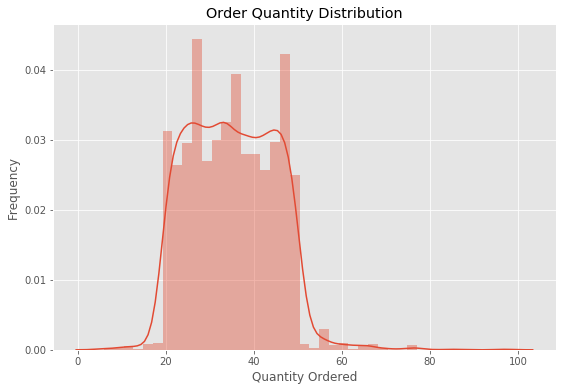

In [8]:
plt.figure(figsize=(9,6))
sns.distplot(df['QUANTITYORDERED'])
plt.title('Order Quantity Distribution')
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.show()

**Objective:**

Dari sebaran distribusi kuantitas, kita dapat menyimpulkan bahwa pesanan yang diterima adalah pesanan massal. Karena sebagian besar jumlah pesanan adalah antara 20 -40 unit.

### Price Distribution

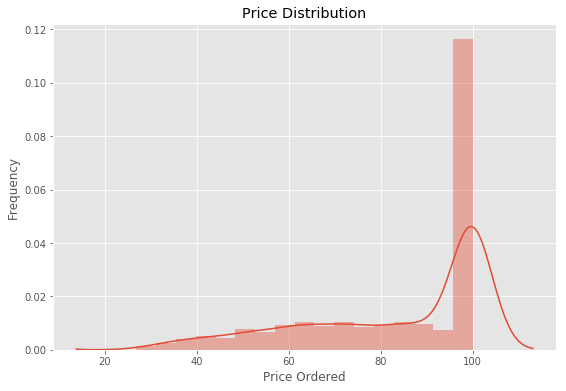

In [9]:
plt.figure(figsize=(9,6))
sns.distplot(df['PRICEEACH'])
plt.title('Price Distribution')
plt.xlabel('Price Ordered')
plt.ylabel('Frequency')
plt.show()

**Objective:**

Sebaran data pada kolom harga adalah '*Left Skewed*' dengan harga maksimal 100 $. Menariknya, banyak pesanan yang diterima dari harga ini. Namun kali ini kita akan fokus untuk membahas segmentasi pelanggan, jadi kita tidak akan menyelidiki lebih lanjut tentang lini produk khusus ini yang memiliki harga tertinggi.

### Sales Distribution

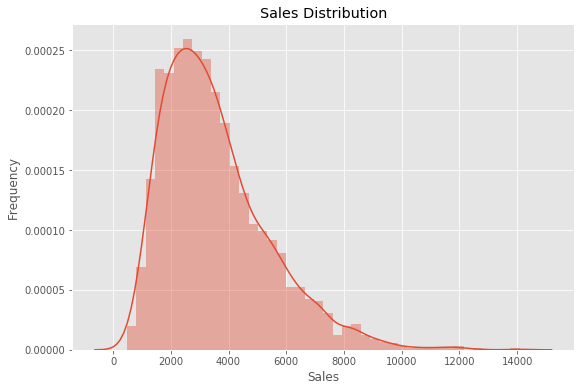

In [10]:
plt.figure(figsize=(9,6))
sns.distplot(df['SALES'])
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

### Analyzing the STATUS variable

In [11]:
df['STATUS'].value_counts(normalize = True)

Shipped       0.927028
Cancelled     0.021254
Resolved      0.016649
On Hold       0.015586
In Process    0.014524
Disputed      0.004959
Name: STATUS, dtype: float64

**Checking the time range of the data**

In [12]:
df.groupby(['YEAR_ID'])['MONTH_ID'].nunique()

YEAR_ID
2003    12
2004    12
2005     5
Name: MONTH_ID, dtype: int64

**Objective:**

Kita tidak memiliki data yang utuh di tahun 2005.

### Dealsize Distribution

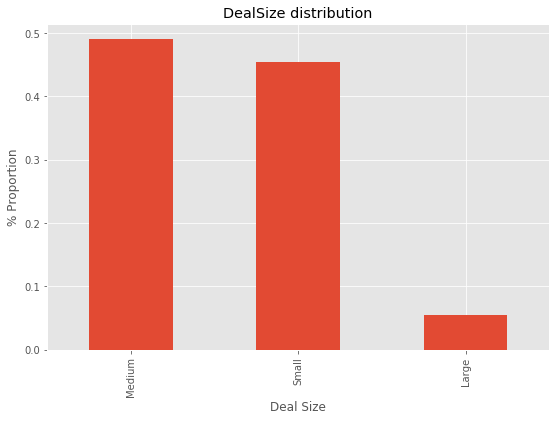

In [13]:
plt.figure(figsize=(9,6))
df['DEALSIZE'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('DealSize distribution')
plt.xlabel('Deal Size')
plt.ylabel('% Proportion')
plt.show()

## Analyzing KPIs

### Pendapatan Tahunan

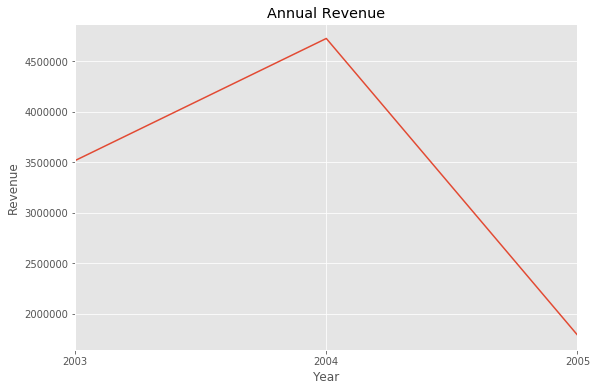

In [14]:
plt.figure(figsize=(9,6))
df.groupby(['YEAR_ID'])['SALES'].sum().plot()
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Annual Revenue')
plt.xticks(np.arange(2003,2006,1))
plt.show()

**Objective:**

Karena kita tidak memiliki data lengkap untuk tahun 2005, maka hasil tidak akan baik jika kita menganalisis Pendapatan Tahunan. Sebagai gantinya, kita dapat menganalisis Pendapatan Bulanan.

### Penghasilan Bulanan

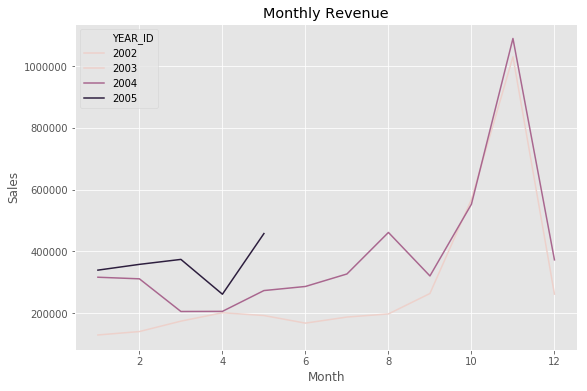

In [15]:
plt.figure(figsize=(9,6))

monthly_revenue = df.groupby(['YEAR_ID','MONTH_ID'])['SALES'].sum().reset_index()
monthly_revenue
sns.lineplot(x="MONTH_ID", y="SALES",hue="YEAR_ID", data=monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Revenue')
plt.show()

**Objective:**

Grafik di atas jelas menunjukkan bahwa pendapatan meningkat terutama pada bulan Oktober dan November. Hal ini bisa jadi hasil dari seasonality (Thanks Giving dan hari perayaan lainnya). Kita juga dapat mengamati bahwa tahun 2005 memiliki kinerja lebih baik daripada tahun-tahun lainnya dalam hal pendapatan dengan penjualan maksimum di semua bulan (Januari - Mei). Alasan di balik lonjakan penjualan di tahun 2005 ini dapat diselidiki lebih lanjut untuk mempertahankan penjualan di masa depan.

### Tingkat pertumbuhan Pendapatan Bulanan

In [16]:
monthly_revenue['MONTHLY GROWTH'] = monthly_revenue['SALES'].pct_change()
monthly_revenue.head()

,YEAR_ID,MONTH_ID,SALES,MONTHLY GROWTH
0,2003,1,129753.60,NaN
1,2003,2,140836.19,0.085413
2,2003,3,174504.90,0.239063
3,2003,4,201609.55,0.155323
4,2003,5,192673.11,-0.044325


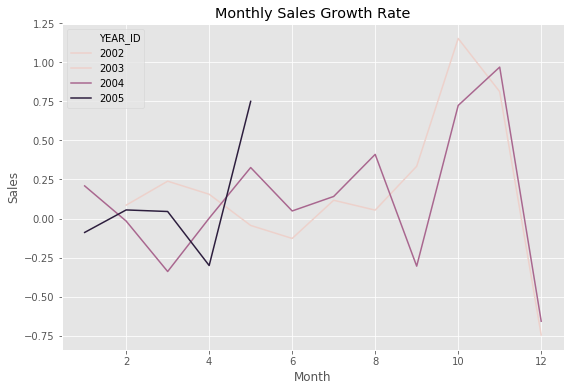

In [17]:
plt.figure(figsize=(9,6))
sns.lineplot(x="MONTH_ID", y="MONTHLY GROWTH",hue="YEAR_ID", data=monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Growth Rate')
plt.show()

**Objective:**

Terlepas dari tingkat pertumbuhan tinggi / rendah yang diharapkan selama seasonal months, ternyata ada tingkat pertumbuhan yang tinggi dari Apr 2005 hingga Mei 2005.

**Top 10 countries by Sales**

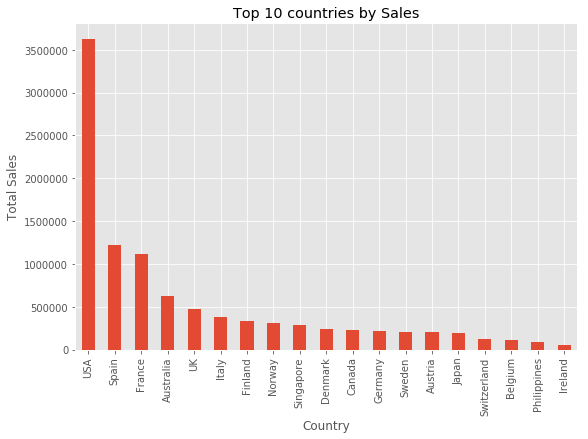

In [18]:
plt.figure(figsize=(9,6))
top_cities = df.groupby(['COUNTRY'])['SALES'].sum().sort_values(ascending=False)
top_cities.plot(kind = 'bar')
plt.title('Top 10 countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()

### Pelanggan Aktif Bulanan

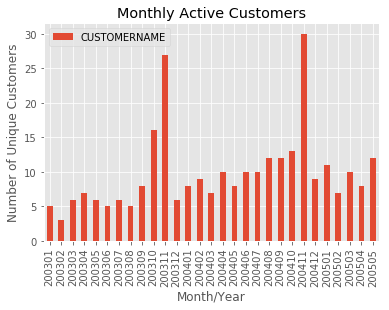

In [19]:
df['YEAR_MONTH'] = df['YEAR_ID'].map(str)+df['MONTH_ID'].map(str).map(lambda x: x.rjust(2,'0'))
monthly_active = df.groupby(['YEAR_MONTH'])['CUSTOMERNAME'].nunique().reset_index()
monthly_active.plot(kind='bar',x='YEAR_MONTH',y='CUSTOMERNAME')

plt.title('Monthly Active Customers')
plt.xlabel('Month/Year')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=90)
plt.show()

**Objective:**

Seperti yang diharapkan, pelanggan sangat aktif selama bulan November dan Oktober. Jumlah pelanggan aktif meningkat dari 2003 ke 2004 yang menunjukkan bahwa perusahaan tersebut berhasil dalam retensi / akuisisi pelanggan baru.

### Penjualan Rata-rata per Pesanan

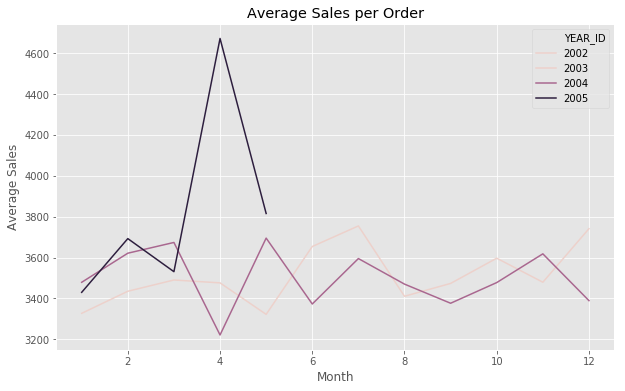

In [20]:
average_revenue = df.groupby(['YEAR_ID','MONTH_ID'])['SALES'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x="MONTH_ID", y="SALES",hue="YEAR_ID", data=average_revenue)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales per Order')
plt.show()

### Tingkat Pertumbuhan Pelanggan Baru

New customer adalah siapa pun yang melakukan pembelian pertamanya di rentang waktu yang kita tentukan, dalam analisis kali ini kita tentukan dalam Monthly.

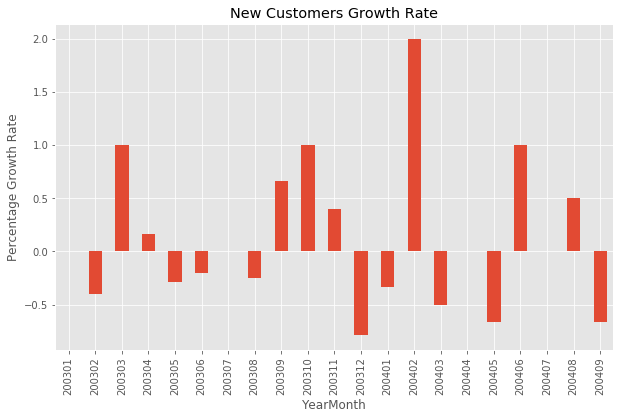

In [21]:
df_first_purchase = df.groupby('CUSTOMERNAME').YEAR_MONTH.min().reset_index()
df_first_purchase.columns = ['CUSTOMERNAME','FirstPurchaseDate']

plt.figure(figsize=(10,6))
df_first_purchase.groupby(['FirstPurchaseDate'])['CUSTOMERNAME'].nunique().pct_change().plot(kind='bar')
plt.title('New Customers Growth Rate')
plt.xlabel('YearMonth')
plt.ylabel('Percentage Growth Rate')
plt.show()

**Objective:**

Tingkat pertumbuhan tertinggi diamati pada Februari 2002. Hal ini dapat diselidiki lebih lanjut untuk lebih memahami faktor-faktor apa yang berkontribusi terhadap pertumbuhan.

### Segmentation with number of clusters chosen randomly

In [22]:
df['ORDERDATE'] = [d.date() for d in df['ORDERDATE']]
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,MSRP,PRODUCTCODE,CUSTOMERNAME,CITY,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,YEAR_MONTH
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,95,S10_1678,Land of Toys Inc.,NYC,USA,NaN,Yu,Kwai,Small,200302
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,95,S10_1678,Reims Collectables,Reims,France,EMEA,Henriot,Paul,Small,200305
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,95,S10_1678,Lyon Souveniers,Paris,France,EMEA,Da Cunha,Daniel,Medium,200307
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,95,S10_1678,Toys4GrownUps.com,Pasadena,USA,NaN,Young,Julie,Medium,200308
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,95,S10_1678,Corporate Gift Ideas Co.,San Francisco,USA,NaN,Brown,Julie,Medium,200310


### Menghitung nilai Recency, Frequency and Monetary untuk setiap pelanggan

Dengan asumsi bahwa kita akan menganalisis hari berikutnya dari tanggal pemesanan terbaru dalam dataset. Membuat variabel '*snapshot date*' yang merupakan tanggal terbaru dalam dataset.

**Recency:** Jumlah hari antara tanggal pesanan terakhir pelanggan dan tanggal foto

**Frequency:** Jumlah pembelian yang dilakukan oleh pelanggan

**MonetaryValue:** Penghasilan yang dihasilkan oleh pelanggan

In [23]:
# Calculate Recency, Frequency and Monetary value for each customer
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days=1) #latest date in the data set
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,
    'ORDERNUMBER': 'count',
    'SALES':'sum'})

#Renaming the columns
df_RFM.rename(columns={'ORDERDATE': 'Recency',
                   'ORDERNUMBER': 'Frequency',
                   'SALES': 'MonetaryValue'}, inplace=True)

df_RFM.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


### Membagi Customer menjadi 4 segments(Randomly Chosen)

**Recency/Frequency/MonetaryValue :** Level 4 > Level 3> Level 2 > Level 1

- Lower the recency, higher the Recency level
- Higher the number of orders, higher the Frequency level
- Higher the monetary value, higher the MonetaryValue level

In [47]:
# Create a spend quartile with 4 groups - a range between 1 and 5
MonetaryValue_quartile = pd.qcut(df_RFM['MonetaryValue'], q=4, labels=range(1,5))
Recency_quartile = pd.qcut(df_RFM['Recency'], q=4, labels=list(range(4, 0, -1)))
Frequency_quartile = pd.qcut(df_RFM['Frequency'], q=4, labels=range(1,5))


# Assign the quartile values to the Spend_Quartile column in data
df_RFM['R'] = Recency_quartile
df_RFM['F'] = Frequency_quartile
df_RFM['M'] = MonetaryValue_quartile

#df_RFM[['MonetaryValue_Quartile','Recency_quartile','Frequency_quartile']] = [MonetaryValue_quartile,Recency_quartile,Frequency_quartile]

# Print data with sorted Spend values
#print(df_RFM.sort_values('MonetaryValue'))

df_RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,2,4,4,10.0,High Value Customer
Alpha Cognac,65,20,70488.44,4,2,2,8.0,Mid Value Customer
Amica Models & Co.,265,26,94117.26,1,2,3,6.0,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,3,4,4,11.0,High Value Customer
Atelier graphique,188,7,24179.96,2,1,1,4.0,Low Value Customer


**Calculating RFM Score**

In [25]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,2,4,4,10.0
Alpha Cognac,65,20,70488.44,4,2,2,8.0
Amica Models & Co.,265,26,94117.26,1,2,3,6.0
"Anna's Decorations, Ltd",84,46,153996.13,3,4,4,11.0
Atelier graphique,188,7,24179.96,2,1,1,4.0


**Labelling the levels**

RFM Score > 10 - **High Value Customer**

RFM SCore < 10 and RFM Score >= 6 - **Mid Value Customer**

RFM Score < 6 - **Low Value Customer**

In [44]:
#Naming Levels
# Define rfm_level function
def rfm_level(df):
    if np.bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    elif np.bool((df['RFM_Score'] < 10) & (df['RFM_Score'] >= 6)):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'

# Create a new variable RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

df_RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,2,4,4,10.0,High Value Customer
Alpha Cognac,65,20,70488.44,4,2,2,8.0,Mid Value Customer
Amica Models & Co.,265,26,94117.26,1,2,3,6.0,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,3,4,4,11.0,High Value Customer
Atelier graphique,188,7,24179.96,2,1,1,4.0,Low Value Customer


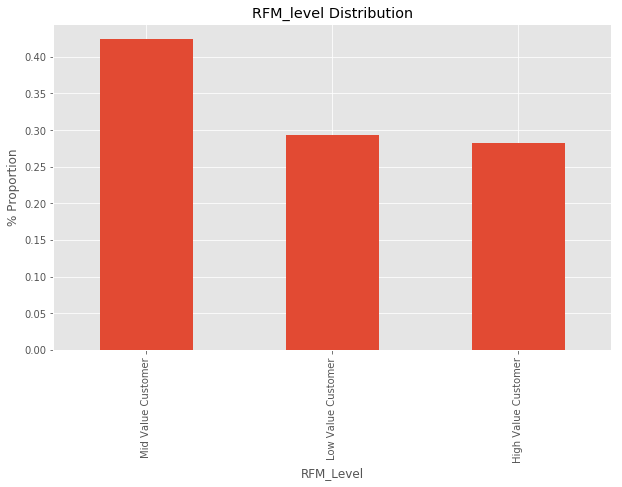

In [27]:
plt.figure(figsize=(10,6))
df_RFM['RFM_Level'].value_counts(normalize = True).plot(kind='bar')
plt.title('RFM_level Distribution')
plt.xlabel('RFM_Level')
plt.ylabel('% Proportion')
plt.show()

### Higher the MonetaryValue, higher the MonetaryValue level

In [43]:
# Nilai rata-rata setiap RFM_Level, dan mengembalikan ukuran masing-masing segmen 
rfm_level_agg = df_RFM.groupby(['RFM_Level']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue':['mean','count']}).round(1)

rfm_level_agg

Recency Frequency MonetaryValue      
                       mean      mean          mean count
RFM_Level                                                
High Value Customer    85.0      54.3      193532.1    26
Low Value Customer    293.8      15.0       52414.6    27
Mid Value Customer    171.2      25.8       91938.5    39

## Segmentation using KMeans Clustering

### Data Preprocessing for KMeans
**K Means Assumptions**

- Semua variabel memiliki symmetrical (Normal) Distribusi
- Semua variabel memiliki nilai rata-rata(approx)
- Semua variabel memiliki varian yang sama(approx)

**Check the distribution of the variables**

In [29]:
data = df_RFM[['Recency','Frequency','MonetaryValue']]
data.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


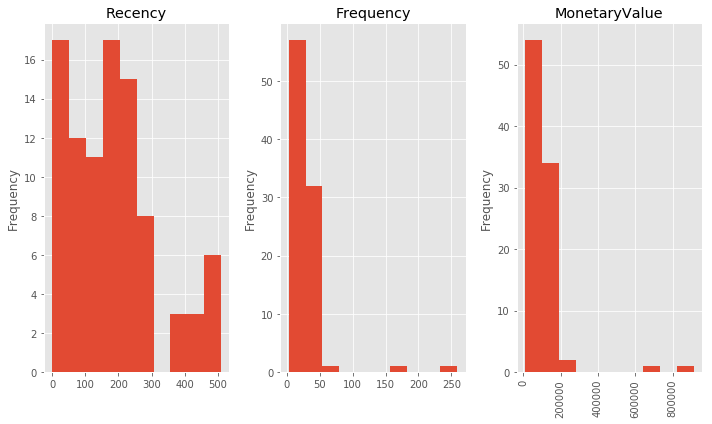

In [30]:
plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
data['Recency'].plot(kind='hist')
plt.title('Recency')

plt.subplot(1,3,2)
data['Frequency'].plot(kind='hist')
plt.title('Frequency')

plt.subplot(1,3,3)
data['MonetaryValue'].plot(kind='hist')
plt.xticks(rotation = 90)
plt.title('MonetaryValue')

plt.tight_layout()
plt.show()

### **Menghapus Skewness untuk mencapai distribusi Normal menggunakan Log Transformation**

In [31]:
data_log = np.log(data)
data_log.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


### Distribusi dari nilai Recency, Frequency dan Monetary setelah Log Transformation

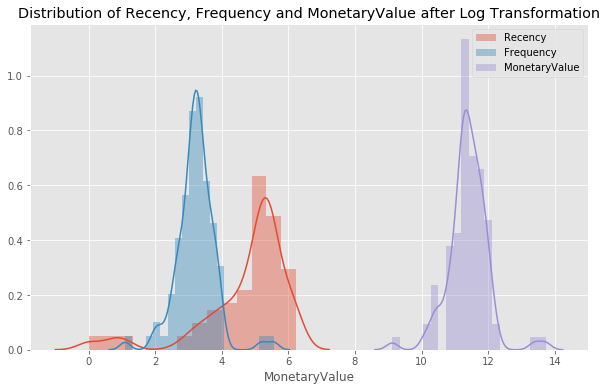

In [32]:
plt.figure(figsize=(10,6))

sns.distplot(data_log['Recency'],label='Recency')

sns.distplot(data_log['Frequency'],label='Frequency')

sns.distplot(data_log['MonetaryValue'],label='MonetaryValue')

plt.title('Distribution of Recency, Frequency and MonetaryValue after Log Transformation')
plt.legend()
plt.show()

### **Standarisasi variabel menggunakan Standard Scaler untuk equal variance dan mean**

In [33]:
# Initialize a scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_normalized = pd.DataFrame(data_normalized, index=data_log.index, columns=data_log.columns)

# Print summary statistics
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


### **Memilih jumlah cluster menggunakan Elbow Method**

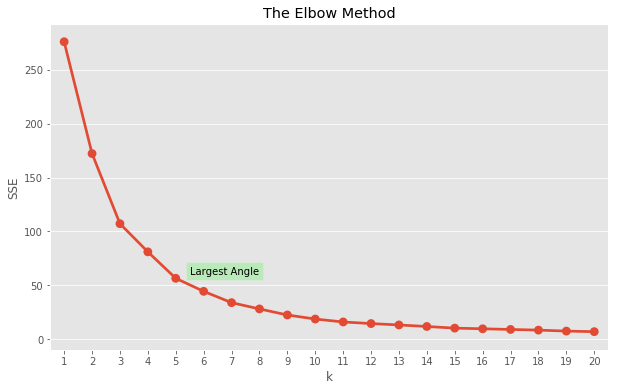

In [34]:
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_ 

    
plt.figure(figsize=(10,6))

plt.title('The Elbow Method')

plt.xlabel('k')

plt.ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(4.5,60,"Largest Angle",bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.show()

**Running KMeans with 5 clusters**

In [35]:
# Initialize KMeans
kmeans = KMeans(n_clusters=5, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(data_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
data_rfm = data.assign(Cluster=cluster_labels)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2


In [36]:
# Group the data by cluster
grouped = data_rfm.groupby(['Cluster'])

# Hitung nilai rata-rata RFM dan ukuran segment per nilai cluster
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         209.2      22.1       78633.2    43
1           2.0      38.8      132201.6     4
2         324.2      10.7       35628.7    12
3         126.5      37.1      133158.0    31
4           2.0     219.5      783576.1     2

## Membangun Persona Pelanggan

Pesona Pelanggan dapat dibangun dengan menentukan statistik ringkasan nilai RFM atau Snake Plot.

Snake Plots adalah teknik Riset Pasar yang digunakan untuk membandingkan segmen.

Representasi visual dari setiap atribut segmen membantu kita untuk menentukan kepentingan relatif dari atribut segmen

**Snake Plot**

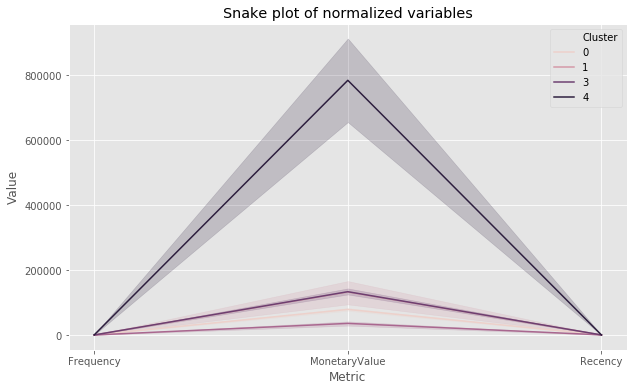

In [37]:
data_rfm_melt = pd.melt(data_rfm.reset_index(), id_vars=['CUSTOMERNAME', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        var_name='Metric', value_name='Value')

plt.figure(figsize=(10,6))

plt.title('Snake plot of normalized variables')

plt.xlabel('Metric')

plt.ylabel('Value')

sns.lineplot(data=data_rfm_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

**Menghitung kepentingan relatif setiap atribut**

In [38]:
# Menghitung nilai rata-rata RFM untuk setiap cluster

cluster_avg = data_rfm.groupby(['Cluster']).mean() 
print(cluster_avg)

            Recency   Frequency  MonetaryValue
Cluster                                       
0        209.162791   22.093023   78633.205814
1          2.000000   38.750000  132201.635000
2        324.250000   10.666667   35628.653333
3        126.548387   37.129032  133158.014516
4          2.000000  219.500000  783576.085000


In [39]:
# Menghitung rata-rata nilai RFM untuk total customer population
population_avg = data.mean()
print(population_avg)

Recency             182.826087
Frequency            30.684783
MonetaryValue    109050.313587
dtype: float64


In [40]:
# Menghitung relative importance dari nilai atribut cluster dibandingkan dengan populasi
relative_imp = cluster_avg / population_avg - 1

# Print relative importance score dan bulatkan menjadi 2 angka dibelakang koma
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0           0.14      -0.28          -0.28
1          -0.99       0.26           0.21
2           0.77      -0.65          -0.67
3          -0.31       0.21           0.22
4          -0.99       6.15           6.19


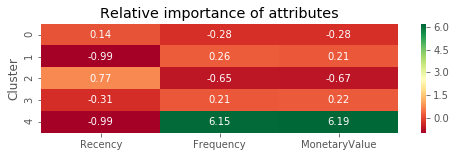

In [41]:
#Plot Relative Importance

plt.figure(figsize=(8, 2))

plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()